In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
import pandas as pd
import numpy as np
import tensorflow as tf
import tensorflow as keras
from sklearn.model_selection import train_test_split
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from sklearn.preprocessing import LabelEncoder
from keras.regularizers import l2
from keras import layers
from keras.models import Sequential, Model
from keras.layers import Embedding, SimpleRNN, Dense, Dropout, LSTM, Bidirectional, Input
from keras.layers import Attention, GlobalAveragePooling1D
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
import stanza
from keras.utils import to_categorical
from keras.layers import BatchNormalization, Dropout

*<h3>Load Data<h3>*

In [3]:
# read csv file into pandas
df = pd.read_csv("../datasets/shuffled7.csv")
df.head(10)

,question_id,answer,grade
0,7,في مكانٍ هادئٍ على جبل النور، حيث يمكن التأمل ...,0
1,7,الوحي نزل في غار حراء.,2
2,7,في جبل النور.,1
3,7,غار حراء - جبل النور موقع نزول الوحي.,2
4,7,نزل الوحي في مكان واحد وهو غار حراء الكائن في ...,2
5,7,منطقة جبل النور .,1
6,7,نزل الوحي على الرسول صلَّى الله عليه وسلَّم في...,2
7,7,غار حراء - جبل النور هما الموقع حيث نزل الوحي.,2
8,7,نزل الوحي في غار حراء - جبل النور بمكة المدينة.,2
9,7,الوحي نزل في غار حراء وجبل النور بمكة المدينة.,2


*<h3>EDA<h3>*

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100 entries, 0 to 99
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   question_id  100 non-null    int64 
 1   answer       100 non-null    object
 2   grade        100 non-null    int64 
dtypes: int64(2), object(1)
memory usage: 2.5+ KB


In [5]:
df.groupby('grade').size()

grade
0    35
1    29
2    36
dtype: int64

In [6]:
df.duplicated().sum()

0

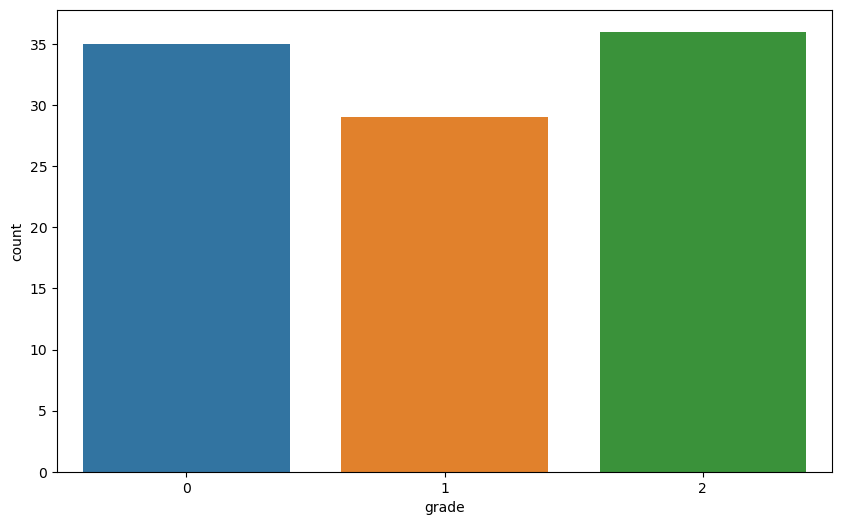

In [7]:
plt.figure(figsize=(10, 6))
sns.countplot(data=df, x='grade')
plt.show()

*<h3>Data Cleaning<h3>*

In [8]:
df.drop('question_id', axis=1, inplace=True)

In [9]:
df.dropna(inplace=True)

In [10]:
df.drop_duplicates(inplace=True)
print(df['answer'])

0     في مكانٍ هادئٍ على جبل النور، حيث يمكن التأمل ...
1                                الوحي نزل في غار حراء.
2                                         في جبل النور.
3                 غار حراء - جبل النور موقع نزول الوحي.
4     نزل الوحي في مكان واحد وهو غار حراء الكائن في ...
                            ...                        
95     جبل النور هو المكان الذي استقبل فيه النبي الوحي.
96                   نزل الوحي في غار حراء - جبل النور.
97    في مكان منعزل ومقدس ظهر نور الوحي للنبي محمد ل...
98    الوحي نزل في مكان واحد وهو غار حراء في جبل النور.
99                  نزل الوحي في غار حراء بمكة الشريفة.
Name: answer, Length: 100, dtype: object


*<h3>Data Pre-Preocessing<h3>*

In [11]:
le = LabelEncoder()
df['grade'] = le.fit_transform(df['grade'])

stanza.download('ar')
nlp = stanza.Pipeline('ar')

def preprocess_text(text):
    doc = nlp(text)
    tokens = [word.lemma for sent in doc.sentences for word in sent.words if word.upos != 'PUNCT']
    return tokens

df['answer'] = df['answer'].apply(preprocess_text)

2024-01-09 22:54:27 INFO: Downloading default packages for language: ar (Arabic) ...
2024-01-09 22:54:29 INFO: File exists: C:\Users\amine\stanza_resources\ar\default.zip
2024-01-09 22:54:34 INFO: Finished downloading models and saved to C:\Users\amine\stanza_resources.
2024-01-09 22:54:34 INFO: Checking for updates to resources.json in case models have been updated.  Note: this behavior can be turned off with download_method=None or download_method=DownloadMethod.REUSE_RESOURCES


2024-01-09 22:54:36 INFO: Loading these models for language: ar (Arabic):
| Processor | Package       |
-----------------------------
| tokenize  | padt          |
| mwt       | padt          |
| pos       | padt_charlm   |
| lemma     | padt_nocharlm |
| depparse  | padt_charlm   |
| ner       | aqmar_charlm  |

2024-01-09 22:54:36 INFO: Using device: cpu
2024-01-09 22:54:36 INFO: Loading: tokenize
2024-01-09 22:54:38 INFO: Loading: mwt
2024-01-09 22:54:38 INFO: Loading: pos
2024-01-09 22:54:38 INFO: Loading: lemma
2024-01-09 22:54:38 INFO: Loading: depparse
2024-01-09 22:54:39 INFO: Loading: ner
2024-01-09 22:54:40 INFO: Done loading processors!


In [12]:
# Tokenization
tokenizer = Tokenizer()
tokenizer.fit_on_texts(df['answer'])
sequences = tokenizer.texts_to_sequences(df['answer'])
max_sequence_length = max(len(s) for s in sequences)
sequences = pad_sequences(sequences,max_sequence_length)
word2idx = tokenizer.word_index
vocab_size = len(word2idx) + 1


X = pad_sequences(sequences, padding='post', truncating='post', maxlen=max_sequence_length)

print(sequences)
print(df['answer'])

Y = to_categorical(df['grade'], num_classes=3)

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.15, random_state=42)


[[  0   0   0 ...  36  80  81]
 [  0   0   0 ...   1  11   8]
 [  0   0   0 ...   1   4   3]
 ...
 [  0   0   0 ...  10 188   7]
 [  0   0   0 ...   1   4   3]
 [  0   0   0 ...  12   9  74]]
0     [فِي, مَكَان, هَادِئ, عَلَى, جَبَل, النور, حَي...
1                        [وَحي, نَزَل, فِي, غَار, حراء]
2                                   [فِي, جَبَل, النور]
3       [غار, حراء, جَبَل, النور, مَوقِع, نُزُول, وَحي]
4     [نَزَل, وَحي, فِي, مَكَان, وَاحِد, وَ, هُوَ, غ...
                            ...                        
95    [جَبَل, النور, هُوَ, مَكَان, اَلَّذِي, اِستَقب...
96          [نَزَل, وَحي, فِي, غار, حراء, جَبَل, النور]
97    [فِي, مَكَان, مُنعَزِل, وَ, مُقَدَّس, ظَهَر, ن...
98    [وَحي, نَزَل, فِي, مَكَان, وَاحِد, وَ, هُوَ, غ...
99    [نَزَل, وَحي, فِي, غَار, حراء, بِ, مَكَّة, شَر...
Name: answer, Length: 100, dtype: object


*<h3>build Models<h3>*

*<h4>RNN Model<h4>*

In [13]:
from tensorflow.keras.callbacks import ReduceLROnPlateau


X_train_rnn, X_test_rnn, y_train_rnn, y_test_rnn = train_test_split(X, Y, test_size=0.2)

def RNN_model(vocab_size, sequence_length):
    model = Sequential()
    model.add(Embedding(input_dim=vocab_size, output_dim=128, input_length=sequence_length))
    model.add(SimpleRNN(units=128, activation='relu', return_sequences=True))
    model.add(BatchNormalization())
    model.add(SimpleRNN(units=64, activation='sigmoid'))
    model.add(Dense(256, activation='sigmoid', kernel_regularizer=l2(0.001)))
    model.add(Dropout(0.2))
    model.add(Dense(3, activation='softmax'))

    optimizer = Adam(learning_rate=0.001)
    
    model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])
    return model

reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=2, min_lr=0.0001, verbose=1)
#EMBEDDING_DIM = 110
rnn_model = RNN_model(vocab_size, max_sequence_length)
early_stopping_rnn = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
history_updated_rnn = rnn_model.fit(X_train_rnn, y_train_rnn, validation_data=(X_test_rnn, y_test_rnn), epochs=100, batch_size=64, callbacks=[reduce_lr])

# Evaluate the RNN model
evaluation_metrics_updated_rnn = rnn_model.evaluate(X_test, Y_test)
print("Evaluation Metrics for RNN:")
for metric_name, metric_value in zip(rnn_model.metrics_names, evaluation_metrics_updated_rnn):
    print(f"{metric_name}: {metric_value}")


Epoch 1/100


2/2 [==============================] - 6s 1s/step - loss: 1.6812 - accuracy: 0.3500 - val_loss: 1.3583 - val_accuracy: 0.3500 - lr: 0.0010
Epoch 2/100
2/2 [==============================] - 0s 100ms/step - loss: 1.2773 - accuracy: 0.3750 - val_loss: 1.2310 - val_accuracy: 0.3500 - lr: 0.0010
Epoch 3/100
2/2 [==============================] - 0s 72ms/step - loss: 1.1591 - accuracy: 0.4125 - val_loss: 1.2169 - val_accuracy: 0.3000 - lr: 0.0010
Epoch 4/100
2/2 [==============================] - 0s 77ms/step - loss: 1.2202 - accuracy: 0.4250 - val_loss: 1.2390 - val_accuracy: 0.3000 - lr: 0.0010
Epoch 5/100
1/2 [==============>...............] - ETA: 0s - loss: 1.1613 - accuracy: 0.4688
Epoch 5: ReduceLROnPlateau reducing learning rate to 0.00020000000949949026.
2/2 [==============================] - 0s 73ms/step - loss: 1.1768 - accuracy: 0.4375 - val_loss: 1.2472 - val_accuracy: 0.3000 - lr: 0.0010
Epoch 6/100
2/2 [==============================] - 0s 66ms/step - loss: 1.1

*<h4>LSTM Model<h4>*

In [14]:
def LSTM_model(vocab_size, sequence_length):
    model = Sequential()
    model.add(Embedding(input_dim=vocab_size, output_dim=128, input_length=sequence_length))
    model.add(LSTM(units=128, activation='relu', return_sequences=True))
    model.add(BatchNormalization())
    model.add(LSTM(units=64, activation='relu'))
    model.add(Dense(256, activation='relu', kernel_regularizer=l2(0.001)))
    model.add(Dropout(0.2))
    model.add(Dense(3, activation='softmax'))

    optimizer = Adam(learning_rate=0.001)

    model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])
    return model


#EMBEDDING_DIM = 110
lstm_model = LSTM_model(vocab_size, max_sequence_length)
early_stopping_rnn = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
history_updated_rnn = lstm_model.fit(X_train_rnn, y_train_rnn, validation_data=(X_test_rnn, y_test_rnn), epochs=100, batch_size=64, callbacks=[early_stopping_rnn])


# Evaluate the lstm model
evaluation_metrics_updated_lstm = lstm_model.evaluate(X_test, Y_test)
print("Evaluation Metrics for LSTM:")
for metric_name, metric_value in zip(lstm_model.metrics_names, evaluation_metrics_updated_lstm):
    print(f"{metric_name}: {metric_value}")

    

Epoch 1/100
2/2 [==============================] - 11s 1000ms/step - loss: 1.1871 - accuracy: 0.4500 - val_loss: 1.1988 - val_accuracy: 0.4500
Epoch 2/100
2/2 [==============================] - 0s 99ms/step - loss: 1.1375 - accuracy: 0.5250 - val_loss: 1.1966 - val_accuracy: 0.6000
Epoch 3/100
2/2 [==============================] - 0s 83ms/step - loss: 1.0666 - accuracy: 0.6125 - val_loss: 1.1938 - val_accuracy: 0.5000
Epoch 4/100
2/2 [==============================] - 0s 79ms/step - loss: 0.9685 - accuracy: 0.6750 - val_loss: 1.1906 - val_accuracy: 0.3500
Epoch 5/100
2/2 [==============================] - 0s 117ms/step - loss: 0.8568 - accuracy: 0.7625 - val_loss: 1.1872 - val_accuracy: 0.3500
Epoch 6/100
2/2 [==============================] - 0s 126ms/step - loss: 0.7058 - accuracy: 0.7750 - val_loss: 1.1840 - val_accuracy: 0.3500
Epoch 7/100
2/2 [==============================] - 0s 122ms/step - loss: 0.5603 - accuracy: 0.8500 - val_loss: 1.1831 - val_accuracy: 0.3500
Epoch 8/100
2/

*<h4>TRANSFORMER Model<h4>*

In [15]:
class TransformerBlock(layers.Layer):
    def __init__(self, embed_dim, num_heads, density, rate=0.1, l2_reg=0.01):
        super(TransformerBlock, self).__init__()
        self.att = layers.MultiHeadAttention(num_heads=num_heads, key_dim=embed_dim)
        self.ffn = tf.keras.Sequential([
            layers.Dense(density, activation="relu", kernel_regularizer=tf.keras.regularizers.l2(l2_reg)),
            layers.Dense(embed_dim, kernel_regularizer=tf.keras.regularizers.l2(l2_reg)),
        ])
        self.layernorm1 = layers.LayerNormalization(epsilon=1e-6)
        self.layernorm2 = layers.LayerNormalization(epsilon=1e-6)
        self.dropout1 = layers.Dropout(rate)
        self.dropout2 = layers.Dropout(rate)

    def call(self, inputs, training):
        attn_output = self.att(inputs, inputs)
        attn_output = self.dropout1(attn_output, training=training)
        out1 = self.layernorm1(inputs + attn_output)
        ffn_output = self.ffn(out1)
        ffn_output = self.dropout2(ffn_output, training=training)
        return self.layernorm2(out1 + ffn_output)


class TokenAndPositionEmbedding(layers.Layer):
    def __init__(self, maxlen, vocab_size, embed_dim):
        super(TokenAndPositionEmbedding, self).__init__()
        self.token_emb = layers.Embedding(input_dim=vocab_size, output_dim=embed_dim)
        self.pos_emb = layers.Embedding(input_dim=maxlen, output_dim=embed_dim)

    def call(self, x):
        maxlen = tf.shape(x)[-1]
        positions = tf.range(start=0, limit=maxlen, delta=1)
        positions = self.pos_emb(positions)
        x = self.token_emb(x)
        return x + positions

def build_transformer_model(maxlen, vocab_size, embed_dim, num_heads, density, transformer_units, mlp_units, dropout_rate, num_classes):
    inputs = layers.Input(shape=(maxlen,))
    embedding_layer = TokenAndPositionEmbedding(maxlen, vocab_size, embed_dim)
    x = embedding_layer(inputs)
    for _ in range(transformer_units):
        x = TransformerBlock(embed_dim, num_heads, density, rate=dropout_rate)(x)
    x = layers.GlobalAveragePooling1D()(x)
    for dim in mlp_units:
        x = layers.Dense(dim, activation="relu")(x)
        x = layers.Dropout(dropout_rate)(x)
    outputs = layers.Dense(num_classes, activation="softmax")(x)
    model = tf.keras.Model(inputs=inputs, outputs=outputs)
    return model

In [16]:
maxlen = max_sequence_length
vocab_size = len(tokenizer.word_index) + 1
embed_dim = 120
num_heads = 2
density = 3
transformer_units = 4
mlp_units = [128]
dropout_rate = 0.5
num_classes = len(df['grade'].unique())

transformer_model = build_transformer_model(maxlen, vocab_size, embed_dim, num_heads, density, transformer_units, mlp_units, dropout_rate, num_classes)


In [17]:
transformer_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
transformer_model.fit(X_train, Y_train, epochs=30, batch_size=32, validation_data=(X_test, Y_test))
history = transformer_model.fit(X_train, Y_train, epochs=30, batch_size=32, validation_data=(X_test, Y_test))


Epoch 1/30
3/3 [==============================] - 20s 1s/step - loss: 1.7473 - accuracy: 0.3882 - val_loss: 1.8682 - val_accuracy: 0.2667
Epoch 2/30
3/3 [==============================] - 0s 83ms/step - loss: 1.9142 - accuracy: 0.3529 - val_loss: 1.8021 - val_accuracy: 0.2000
Epoch 3/30
3/3 [==============================] - 0s 99ms/step - loss: 1.6629 - accuracy: 0.4471 - val_loss: 1.4072 - val_accuracy: 0.6667
Epoch 4/30
3/3 [==============================] - 0s 84ms/step - loss: 1.5285 - accuracy: 0.4706 - val_loss: 1.3127 - val_accuracy: 0.8000
Epoch 5/30
3/3 [==============================] - 0s 88ms/step - loss: 1.4059 - accuracy: 0.5412 - val_loss: 1.2533 - val_accuracy: 0.4000
Epoch 6/30
3/3 [==============================] - 0s 88ms/step - loss: 1.1766 - accuracy: 0.6471 - val_loss: 1.1673 - val_accuracy: 0.4000
Epoch 7/30
3/3 [==============================] - 0s 98ms/step - loss: 1.0414 - accuracy: 0.6235 - val_loss: 1.0548 - val_accuracy: 0.5333
Epoch 8/30
3/3 [===========

In [18]:
evaluation_metrics_transformer = transformer_model.evaluate(X_test, Y_test)
print("Evaluation Metrics Transformer:")
for metric_name, metric_value in zip(transformer_model.metrics_names, evaluation_metrics_transformer):
    print(f"{metric_name}: {metric_value}")


1/1 [==============================] - 0s 223ms/step - loss: 2.6292 - accuracy: 0.6667
Evaluation Metrics Transformer:
loss: 2.6291909217834473
accuracy: 0.6666666865348816


In [19]:
evaluation_metrics_transformer = transformer_model.evaluate(X_test, Y_test)

predictions = transformer_model.predict(X_test)
print(X_test)

# Convert one-hot encoded labels to class indices
y_true = np.argmax(Y_test, axis=1)

# Convert predicted probabilities to class indices
y_pred = np.argmax(predictions, axis=1)

# Create DataFrame
results_df = pd.DataFrame({"Real": y_true, "Predicted": y_pred})

# Display DataFrame
print("\nReal and Predicted Values:")
print(results_df)


1/1 [==============================] - 1s 1s/step
[[  0   0   0   0   0   0   0   0   0   0   0   0   0   5   2   1  11   8
   12   9  21]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   4
    3  12   9]
 [  0   0   0   0   0   0   0   0   1 160   7 161  42   6  13  15  56  34
   12  26   2]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   5   2   1  11
    8  12   9]
 [  0   0   0   0   1 126  30   7  32  61  14  17  14   6   7  10  20  38
   39   2  62]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   2   5   1  11   8
   12   4   3]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0 100   1  40
   41   9  22]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   5   2   1  11   8
   10   4   3]
 [  0   0   0   0   0  87  88  47   6  19  14  17  14   6   7  10  20   1
   89  30   7]
 [  0   0   0   0   0   0   0   1  16  76   6   4   3  25  77  78  10  79
   36  80  81]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   

In [20]:
# Evaluate RNN model
rnn_accuracy = rnn_model.evaluate(X_test, Y_test, verbose=0)[1]
print("Accuracy RNN:", rnn_accuracy)

# Evaluate LSTM model
lstm_accuracy = lstm_model.evaluate(X_test, Y_test, verbose=0)[1]
print("Accuracy LSTM:", lstm_accuracy)

# Evaluate Transformer model
transformer_accuracy = transformer_model.evaluate(X_test, Y_test, verbose=0)[1]
print("Accuracy Transformer:", transformer_accuracy)



Accuracy RNN: 0.9333333373069763
Accuracy LSTM: 0.9333333373069763
Accuracy Transformer: 0.6666666865348816


In [21]:
# Determine the best model
best_model_name, best_model_accuracy = max([('RNN', rnn_accuracy), ('LSTM', lstm_accuracy), ('Transformer', transformer_accuracy)], key=lambda x: x[1])

save_path = './savedModels/q7_model.h5'
# Save the best model
if best_model_name == 'RNN':
    rnn_model.save(save_path)
elif best_model_name == 'LSTM':
    lstm_model.save(save_path)
elif best_model_name == 'Transformer':
    transformer_model.save(save_path)

print(f"The best model ({best_model_name}) with accuracy {best_model_accuracy} has been saved to '{save_path}'")


The best model (RNN) with accuracy 0.9333333373069763 has been saved to './savedModels/q7_model.h5'
